In this version I have turned Kb and Kc into arrays of precalculated values to improve run time

# Installs and imports

In [ ]:
!pip install agentpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 KB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 758.0/758.0 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 6.1 MB/s eta 0:00:00


In [ ]:
import agentpy as ap
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import IPython

# Setup

### Initialise seed

In [ ]:
seed = 42
#print(seed)

### Helper functions

In [ ]:
def A(p,K,n):
    return p**n/(p**n+K**n)

def R(p,K,n):
    return K**n/(p**n+K**n)

@np.vectorize
def constrain(x):
    return np.max([np.min([x,1.0]),0.0])

## Defining how $K_c$ varies across space

In [ ]:
space_shape = np.array([300,100],dtype=np.float64)
bin_width = 10
P1_cost_centre = (0.1*space_shape[0],0.5*space_shape[1])
P2_cost_centre = (0.9*space_shape[0],0.5*space_shape[1])
Kc_functions = [lambda x,y: 10+2000*np.exp(-0.00005*((x-P1_cost_centre[0])**2+(y-P1_cost_centre[1])**2)),
                lambda x,y: 10+2000*np.exp(-0.00005*((x-P2_cost_centre[0])**2+(y-P2_cost_centre[1])**2))]
Kb_functions = [np.vectorize(lambda x,y: 0.5),
               np.vectorize(lambda x,y: 0.5)]

In [ ]:
grid_resolution = np.array([3000,1000])
x_grid,y_grid = np.meshgrid(np.linspace(0,space_shape[0],grid_resolution[0]),
                            np.linspace(0,space_shape[1],grid_resolution[1]))
Kb = [f(x_grid,y_grid) for f in Kb_functions] # list of np arrays
Kc = [f(x_grid,y_grid) for f in Kc_functions]

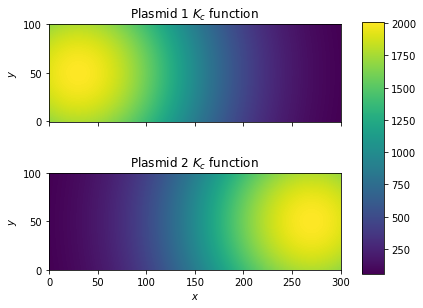

In [ ]:
# Plotting the Kc distributions
# Create the figure and axis objects
fig, ax = plt.subplots(nrows=2, figsize=(6, 5), sharex=True, sharey=False)

im1 = ax[0].pcolormesh(x_grid, y_grid, Kc[0])
ax[0].set_title("Plasmid 1 $K_c$ function")
im2 = ax[1].pcolormesh(x_grid, y_grid, Kc[1])
ax[1].set_title("Plasmid 2 $K_c$ function")

# Add colorbar and move things around
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im2, cax=cbar_ax, orientation='vertical', shrink=0.6, pad=0.02)

# Set the labels for the x and y axes
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$y$')
ax[0].set_ylabel('$y$')

# set aspect ratio
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

#plt.savefig('Kc plots.pdf')
plt.show()

## Defining model parameters

In [ ]:
universal_model_params = dict( # parameters common to other implementations of the plasmid cost model written with dict() function and equals signs for easy copy pasting
                              Kd = np.array([1000,1000],#,100],
                                            dtype=np.float64),
                              Kb = np.array(Kb).transpose(1,2,0), # rearrange to a grid of (Kb1,Kb2) pairs
                              Kc = np.array(Kc).transpose(1,2,0),
                              g = 1,
                              d = 0.02,
                              r2 = 1,
                              C = 10000,
                              S = 10000,
                              dup_ori = True,
                              ptot = 50
                              ) 
params = universal_model_params | { # merge universal parameters dictionary with parameters specific to the agent based model
         "steps":3000,# steps is a parameter used by AgentPy to determine how long the simulation should run
         "population":1000,
         "num_plasmids":2,
         "diffusion":1.5,
         "colour_mode":"plasmids",
         "num_dimensions":2,
         "space_shape":space_shape,
         "bin_width":bin_width,
         "grid_resolution":grid_resolution}

## Defining the model

In [ ]:
class Cell(ap.Agent):
    def setup(self):
        num_plasmids = self.model.p.num_plasmids
        self.plasmid_CNs = 10*np.ones(self.model.p.num_plasmids,dtype=int) # 1 x num_plasmids array
        if self.model.p.colour_mode=="lineage_tracing":
            self.colour = np.random.rand(3)
        elif self.model.p.colour_mode=="plasmids":
            self.colour = constrain(self.plasmid_CNs/self.model.p.ptot)
            if num_plasmids < 3:
                self.colour = np.append(self.colour,0.5*np.ones(shape=3-num_plasmids))

    def setup_pos(self,space):
        self.space = space
        self.pos = space.positions[self]
        pos_grid_index = np.floor(self.pos/self.model.p.grid_resolution).astype(int)
        self.Kb = self.model.p.Kb[pos_grid_index]
        self.Kc = self.model.p.Kc[pos_grid_index]

    def update_plasmids(self):# probability plasmids are replicated when all same ori  
        num_plasmids = self.model.p.num_plasmids
        ptot = self.model.p.ptot
        r2 = self.model.p.r2
        if self.model.p.dup_ori:
            plasmid_replication_probs = np.ones(num_plasmids)*r2*(1-(np.sum(self.plasmid_CNs))/ptot)
        else: #  probability plasmids are replicated given different oris
            plasmid_replication_probs=r2*(1-self.plasmid_CNs/(ptot/num_plasmids))
         
        plasmid_replication_probs = constrain(plasmid_replication_probs) # constrain plasmid_replication_probs between 0 and 1
        if np.any(self.plasmid_CNs <0): print(self.plasmid_CNs)
        self.plasmid_CNs +=np.random.binomial(self.plasmid_CNs, plasmid_replication_probs); # increase the number of plasmids by the number of replicating plasmids, sampled from a binomial distribution
        if self.model.p.colour_mode=="plasmids":
            self.colour = constrain(self.plasmid_CNs/self.model.p.ptot)
            if num_plasmids < 3:
                self.colour = np.append(self.colour,0.5*np.ones(shape=3-num_plasmids))

    def update_death(self):
        S = self.model.p.S
        d = self.model.p.d
        Kd = self.model.p.Kd
        death_prob = A(len(self.model.agents),S,2)+d*np.sum(A(self.plasmid_CNs,Kd,4))
        if np.any(self.plasmid_CNs==0): 
            death_prob=1.0 # cell dies if it loses any plasmid
        if np.random.rand() < death_prob:
            self.model.agents.remove(self)
            self.space.remove_agents([self])

    def update_division(self):
        g = self.model.p.g
        C = self.model.p.C
        Kb = self.Kb
        Kc = self.Kc
        num_plasmids = self.model.p.num_plasmids
        num_dimensions = self.model.p.num_dimensions

        division_prob = constrain(g*(1-len(self.model.agents)/C)*np.prod(A(self.plasmid_CNs,Kb,4))*np.prod(R(self.plasmid_CNs,Kc,4)))
        if np.random.rand() < division_prob:
            daughter_plasmid_CNs = np.random.binomial(self.plasmid_CNs,0.5)
            daughter_cell = Cell(self.model)
            self.model.agents.append(daughter_cell)
            daughter_cell.plasmid_CNs = daughter_plasmid_CNs
            if self.model.p.colour_mode=="lineage_tracing":
                daughter_cell.colour = self.colour
            self.plasmid_CNs -= daughter_plasmid_CNs
            self.space.add_agents([daughter_cell])
            daughter_cell.setup_pos(self.space)
            daughter_cell.space.move_to(daughter_cell,self.pos + np.random.normal(0,0.1,size=num_dimensions))
            if self.model.p.colour_mode=="plasmids":
                self.colour = constrain(self.plasmid_CNs/self.model.p.ptot)
                if num_plasmids < 3:
                    self.colour = np.append(self.colour,0.5*np.ones(shape=3-num_plasmids))

    def update_pos(self):
        self.space.move_by(self,np.random.normal(0,self.model.p.diffusion,size=self.model.p.num_dimensions))
        pos_grid_index = np.floor(self.pos/self.model.p.grid_resolution).astype(int)
        self.Kb = self.model.p.Kb[pos_grid_index]
        self.Kc = self.model.p.Kc[pos_grid_index]


`self.p` is the set of parameters associated with the Model object

In [ ]:
class CellsModel(ap.Model):
    """
    Spatial stochastic model of plasmid buffering
    """
    def setup(self):
        self.space = ap.Space(self,shape=self.p.space_shape)
        self.agents = ap.AgentList(self,self.p.population, Cell)
        self.space.add_agents(self.agents, random=True)
        self.agents.setup_pos(self.space)
    
    def step(self):
        self.agents.update_plasmids()
        self.agents.update_death()
        if len(self.agents)==0:
            self.stop()
        self.agents.update_division()
        self.agents.update_pos()
    
    def update(self):
        """ Record variables after setup and each step. """
        self["N"]=len(self.agents)
        self.record("N")
        try:self["P1"]=sum([agent.plasmid_CNs[0] for agent in self.agents])/len(self.agents)
        except ZeroDivisionError: print(self.model.t)
        try:self["P2"]=sum([agent.plasmid_CNs[1] for agent in self.agents])/len(self.agents)
        except ZeroDivisionError: pass
        
        self.record("N")
        self.record("P1")
        self.record("P2")

        #self["P1_dist"]=[agent.plasmid_CNs[1] for agent in self.agents]
        #self.record("P1_dist")

        # Spatial distribution analysis
        """
        x_bins = [(lower_lim,lower_lim + self.p.bin_width) for lower_lim in np.arange(0,self.p.space_shape[0],self.p.bin_width)]
        for i in range(len(x_bins)):
            lower_lim,upper_lim = x_bins[i]
            # np.nanmean is used to ignore NaN values arising from division by 0 when the number of P2 is 0. A sufficiently large bin_width should be used to minimise this
            self[f"P2P1ratio_bin{i}"]=np.nanmean([agent.plasmid_CNs[1]/agent.plasmid_CNs[0] for agent in self.agents 
                                                                 if agent.pos[0] > lower_lim and agent.pos[0] < upper_lim])
            self.record(f"P2P1ratio_bin{i}")
        #"""

# Running the simulation

In [ ]:
params["dup_ori"] = True
m = CellsModel(params)
results = m.run(seed=seed)

<ipython-input-10-7c949f105a6e>:41: RuntimeWarning: divide by zero encountered in long_scalars
  self[f"P2P1ratio_bin{i}"]=np.nanmean([agent.plasmid_CNs[1]/agent.plasmid_CNs[0] for agent in self.agents


Completed: 705 steps

<ipython-input-10-7c949f105a6e>:41: RuntimeWarning: Mean of empty slice
  self[f"P2P1ratio_bin{i}"]=np.nanmean([agent.plasmid_CNs[1]/agent.plasmid_CNs[0] for agent in self.agents


Completed: 3000 steps
Run time: 0:18:44.493327
Simulation finished


In [ ]:
results.variables.CellsModel

,N,P1,P2,P2P1ratio_bin0,P2P1ratio_bin1,P2P1ratio_bin2,P2P1ratio_bin3,P2P1ratio_bin4,P2P1ratio_bin5,P2P1ratio_bin6,...,P2P1ratio_bin20,P2P1ratio_bin21,P2P1ratio_bin22,P2P1ratio_bin23,P2P1ratio_bin24,P2P1ratio_bin25,P2P1ratio_bin26,P2P1ratio_bin27,P2P1ratio_bin28,P2P1ratio_bin29
t,,,,,,,,,,,,,,,,,,,,,
0,1000,10.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1068,14.847378,14.861423,1.046191,0.992187,1.014632,1.030615,0.987517,0.999753,0.944183,...,0.984948,1.094362,inf,0.999087,1.006308,0.968553,1.122589,inf,1.011270,1.036864
2,1096,19.667883,19.665146,1.083513,1.000498,1.038514,1.131269,1.046291,1.008895,0.938710,...,0.972265,1.053316,1.144209,0.999194,1.037387,1.007457,1.162421,1.296599,1.068780,1.062732
3,1108,22.254513,22.208484,1.026748,1.046055,1.117614,1.164504,1.023936,1.017302,0.950011,...,1.065134,1.100720,1.149905,1.048546,1.027165,1.085390,1.439631,1.246540,0.953000,1.289691
4,1116,23.058244,22.947133,1.005810,1.032721,1.097116,1.165672,0.994302,1.052836,0.916902,...,1.044188,1.065928,1.158632,1.070297,1.029004,1.066573,1.583991,1.339939,1.030861,1.390755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,130,25.176923,25.869231,1.528661,1.149253,0.853333,0.986214,1.148580,0.960381,1.139258,...,0.315789,1.055482,0.946116,1.006551,1.275433,0.651822,1.208333,0.856862,1.166763,1.142641
2997,130,25.176923,25.869231,1.502932,1.245718,1.003671,0.888395,1.101820,0.960381,1.139258,...,0.591228,1.055482,0.946116,1.066782,1.117865,0.651822,1.208333,0.856862,1.246782,1.067447
2998,130,25.176923,25.869231,1.502932,1.182148,1.127754,0.906681,1.132269,0.929643,1.193304,...,0.848698,0.978443,0.889167,1.082087,1.066244,0.858790,1.208333,0.840849,1.198385,0.957649


# Plotting

Text(0, 0.5, 'cell number')

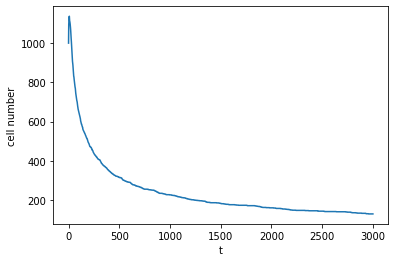

In [ ]:
t = results.variables.CellsModel.index
plt.plot(t,results.variables.CellsModel["N"])
plt.xlabel("t")
plt.ylabel("cell number")

Text(0, 0.5, 'plasmid copy number')

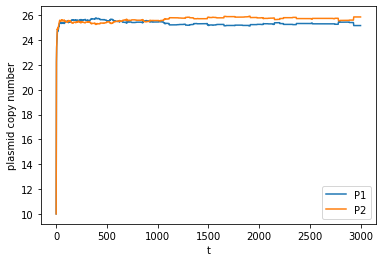

In [ ]:
plt.plot(t,results.variables.CellsModel["P1"])
plt.plot(t,results.variables.CellsModel["P2"])
plt.legend(["P1","P2"])
plt.xlabel("t")
plt.ylabel("plasmid copy number")

Text(0, 0.5, 'mean P2:P1 ratio')

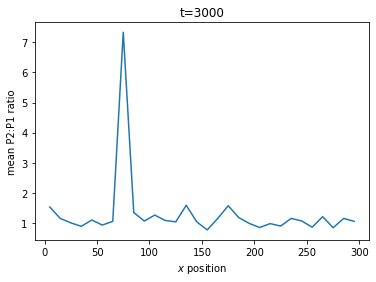

In [ ]:
t=3000
xs=[(i+0.5)*bin_width for i in range(int(space_shape[0]/bin_width))]
ys=[results.variables.CellsModel[f"P2P1ratio_bin{i}"][t] for i in range(int(space_shape[0]/bin_width))]
plt.plot(xs,ys)
plt.title(f"t={t}")
plt.xlabel("$x$ position")
plt.ylabel("mean P2:P1 ratio")

# Running and animating

In [ ]:
matplotlib.rcParams['animation.embed_limit'] = 2**128 # allow large animations to be displayed

In [ ]:
def animation_plot_single(m,ax):
    pos = m.space.positions.values() or [0,0]
    colours = m.agents.colour
    pos = np.array(list(pos)).T  # transform to list of x and y coords
    ax.set_aspect('equal')
    ax.scatter(*pos,s=1,c=colours)
    ax.set_title(f"t={m.t}")

def animation_plot(m,p,seed=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    animation = ap.animate(m(p),fig,ax,animation_plot_single,seed=seed)
    return animation

In [ ]:
params["colour_mode"]="plasmids"
params["steps"]=3010
animation = animation_plot(CellsModel,params,seed=seed)

In [ ]:
animation.save("agent based.mp4",dpi=400)

In [ ]:
IPython.display.HTML(animation.to_jshtml(fps=20))

In [ ]:
params["colour_mode"]="lineage_tracing"
animation2 = animation_plot(CellsModel,params,seed=seed)
IPython.display.HTML(animation2.to_jshtml(fps=20))

In [ ]:
animation2.save("lineage_trace.mp4")

In [ ]:
IPython.display.HTML(animation2.to_jshtml(fps=20))

In [ ]:
params["colour_mode"]="plasmids"
animation_plot(CellsModel,params)